In [53]:
from astropy.io import fits, ascii
from astropy.table import Table, Column, hstack
from astropy.time import Time
import numpy as np
import rafias_lib as rl
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## General

In [57]:
telem_table = ascii.read('/data1/tso_analysis/all_tso_cv3/temperatures/cv3_otp821_telem.CSV')
time_list = []
for time in telem_table['Secondary Time']:
    time_list.append(string.replace(string.replace(time, '/', '-'), ' ', 'T'))
Tlist = Time(time_list)
telem_table['JD'] = Tlist.jd
telem_table

Primary Time,Secondary Time,APID,Telemetry Mnemonic,EU Value,Flags,Raw Type,Raw Value,JD
str23,str23,int64,str23,str21,int64,str4,int64,float64
2016/01/11 00:00:00.000,2016/01/10 18:00:57.179,778,INRC_FA_TMC1_SW_HTR_ST,ENABLE,0,CS,1,2457398.25066
2016/01/11 00:00:00.000,2016/01/10 18:00:57.179,778,INRC_FA_TMC2_SW_HTR_ST,ENABLE,0,CS,1,2457398.25066
2016/01/11 00:00:00.000,2016/01/10 18:01:03.227,779,INRC_FB_TMC1_SW_HTR_ST,ENABLE,0,CS,1,2457398.25073
2016/01/11 00:00:00.000,2016/01/10 18:01:03.227,779,INRC_FB_TMC2_SW_HTR_ST,ENABLE,0,CS,1,2457398.25073
2016/01/11 00:00:00.000,2016/01/10 08:21:51.665,-1,IGDP_NRC_FA_TMC2_SWMV_T,9.054495271677895e+01,0,FL32,0,2457397.84851
2016/01/11 00:00:00.000,2016/01/07 20:31:56.977,-1,IGDP_NRC_FB_TMC2_SWMV_T,2.895544870499462e+02,0,FL32,0,2457395.35552
2016/01/11 00:00:00.000,2016/01/10 23:59:42.819,-1,IGDP_NRC_A_T_SWFPAH1,3.736645780735095e+01,5,FL32,0,2457398.4998
2016/01/11 00:00:00.000,2016/01/10 23:59:10.948,-1,IGDP_NRC_B_T_SWFPAH1,3.760912863591025e+01,5,FL32,0,2457398.49943
2016/01/11 00:00:00.000,2016/01/10 23:59:58.639,-1,IGDP_NRC_FA_TMC1_SWMV_T,3.720505137821176e+01,5,FL32,0,2457398.49998


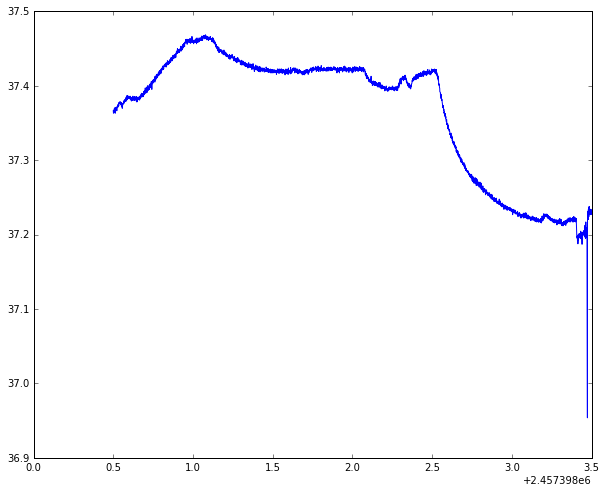

In [58]:
index = np.where(telem_table['Telemetry Mnemonic'] == 'IGDP_NRC_A_T_SWFPAH1')
x = telem_table['JD'][index]
y = telem_table['EU Value'][index]
plt.plot(x, y)

In [60]:
def closest_value(array, value):
    ind = (np.abs(array - value)).argmin()
    val = array[ind]
    return ind, val

## Test 1 (WLP8SUB)

In [86]:
hdu_filenames_a11 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/*.slp.fits')
len(hdu_filenames_a11)

306

In [55]:
hdu_filenames_b41 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-6012134957_1_489_SE_2016-01-12T16h43m29/*.slp.fits')
len(hdu_filenames_b41)

307

In [56]:
centers_a11 = rl.gen_center_g2d(166,160,5,400,2,2,0,hdu_filenames_a11)
centers_b41 = rl.gen_center_g2d(162,156,5,500,2,2,0,hdu_filenames_b41)
data1 = rl.average_residual_flux(centers_a11, centers_b41, 90, 100, 110, hdu_filenames_a11, hdu_filenames_b41)

In [95]:
hdu = fits.open(hdu_filenames_a11[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

2457400.07915 2457400.15841 1885 1980


In [96]:
jd_time = data1['Time']/86400

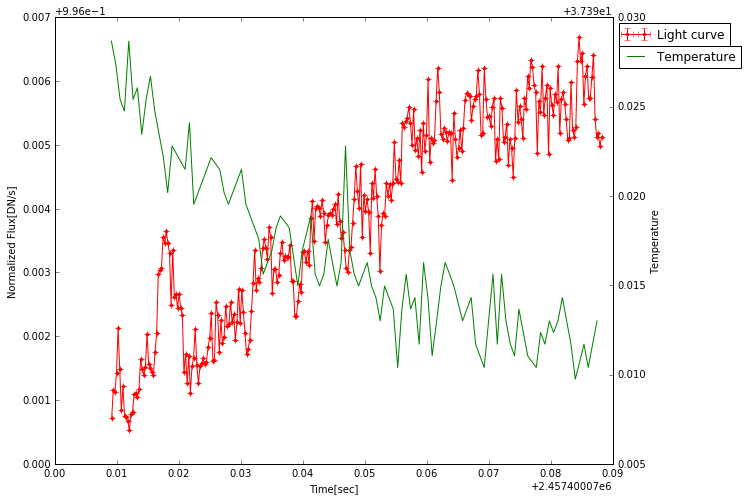

In [97]:
x1 = jd_time + stime
y1 = data1['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))

## Test 2 (WLP8SUB640)

In [87]:
hdu_filenames_a12 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8SUB640-6012195832_1_481_SE_2016-01-12T20h57m57/*.slp.fits')
len(hdu_filenames_a12)

60

In [88]:
hdu_filenames_b42 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8SUB640-6012200140_1_489_SE_2016-01-12T20h58m27/*.slp.fits')
len(hdu_filenames_b42)

60

In [ ]:
centers_a12 = rl.gen_center_g2d(326,320,5,400,2,2,0,hdu_filenames_a12)
centers_b42 = rl.gen_center_g2d(319,316,5,500,2,2,0,hdu_filenames_b42)
data2 = rl.average_residual_flux(centers_a12, centers_b42, 90, 100, 110, hdu_filenames_a12, hdu_filenames_b42)

In [ ]:
hdu = fits.open(hdu_filenames_a12[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

In [ ]:
jd_time = data2['Time']/86400

In [ ]:
x1 = jd_time + stime
y1 = data2['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))

## Test 3 (FULLQ)

In [101]:
hdu_filenames_a13 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULLQ-6013001651_1_481_SE_2016-01-13T01h03m43/*.red.fits')
len(hdu_filenames_a13)

55

In [102]:
hdu_filenames_b43 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULLQ-6013002009_1_489_SE_2016-01-13T01h03m23/*.red.fits')
len(hdu_filenames_b43)

55

In [124]:
centers_a13 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a13, red_files = True)
centers_b43 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b43, red_files = True)
data3 = rl.average_residual_flux(centers_a13, centers_b43, 60, 80, 90, 
                                 hdu_filenames_a13, hdu_filenames_b43, red_files = True)

In [125]:
hdu = fits.open(hdu_filenames_a13[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

2457400.51816 2457400.53866 2421 2446


In [126]:
jd_time = data3['Time']/86400

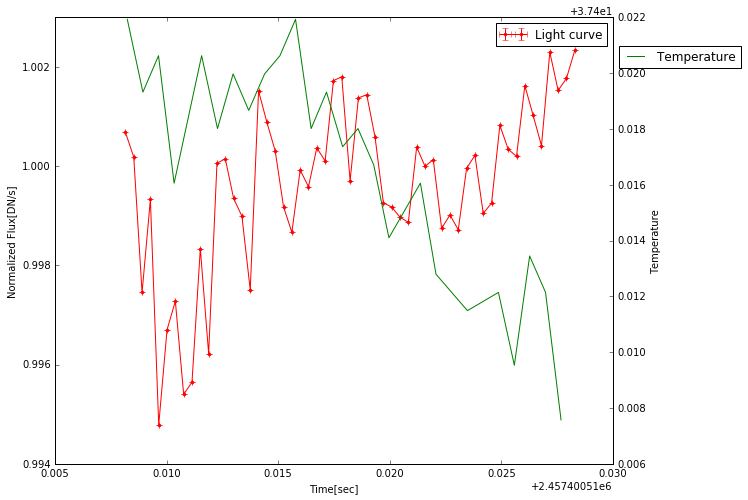

In [127]:
x1 = jd_time + stime
y1 = data3['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))

## Test 4 (FULL1)

In [112]:
hdu_filenames_a14 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL1-6012051326_1_481_SE_2016-01-12T08h55m24/*.red.fits')
len(hdu_filenames_a14)

225

In [113]:
hdu_filenames_b44 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL1-6012051528_1_489_SE_2016-01-12T08h30m07/*.red.fits')
len(hdu_filenames_b44)

225

In [128]:
centers_a14 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a14, red_files = True)
centers_b44 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b44, red_files = True)
data4 = rl.average_residual_flux(centers_a14, centers_b44, 60, 80, 90, 
                                 hdu_filenames_a14, hdu_filenames_b44, red_files = True)

In [129]:
hdu = fits.open(hdu_filenames_a14[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

2457399.72066 2457399.80454 1472 1571


In [130]:
jd_time = data4['Time']/86400

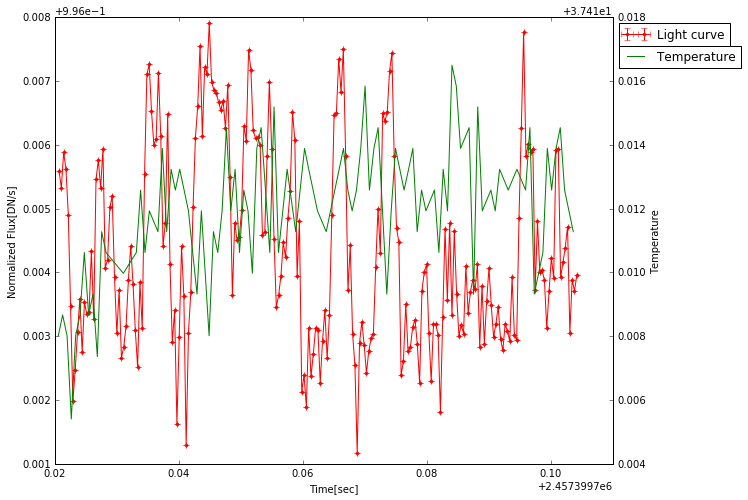

In [131]:
x1 = jd_time + stime
y1 = data4['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))

## Test 5 (FULL2)

In [121]:
hdu_filenames_a15 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL2-6012072417_1_481_SE_2016-01-12T10h40m58/*.red.fits')
len(hdu_filenames_a15)

225

In [122]:
hdu_filenames_b45 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL2-6012072532_1_489_SE_2016-01-12T11h09m06/*.red.fits')
len(hdu_filenames_b45)

225

In [132]:
centers_a15 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a15, red_files = True)
centers_b45 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b45, red_files = True)
data5 = rl.average_residual_flux(centers_a15, centers_b45, 60, 80, 90, 
                                 hdu_filenames_a15, hdu_filenames_b45, red_files = True)

In [133]:
hdu = fits.open(hdu_filenames_a15[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

2457399.81038 2457399.89426 1578 1672


In [134]:
jd_time = data5['Time']/86400

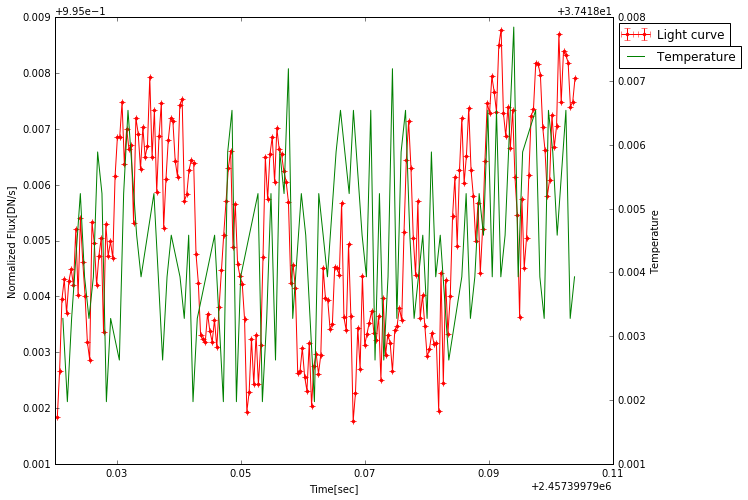

In [135]:
x1 = jd_time + stime
y1 = data5['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))

## Test 6 (FULL3)

In [136]:
hdu_filenames_a16 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL3-6012093326_1_481_SE_2016-01-12T12h47m44/*.red.fits')
len(hdu_filenames_a16)

225

In [137]:
hdu_filenames_b46 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL3-6012093432_1_489_SE_2016-01-12T12h52m21/*.red.fits')
len(hdu_filenames_b46)

225

In [138]:
centers_a16 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a16, red_files = True)
centers_b46 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b46, red_files = True)
data6 = rl.average_residual_flux(centers_a16, centers_b46, 60, 80, 90, 
                                 hdu_filenames_a16, hdu_filenames_b46, red_files = True)

In [139]:
hdu = fits.open(hdu_filenames_a16[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

2457399.9001 2457399.98398 1676 1773


In [140]:
jd_time = data6['Time']/86400

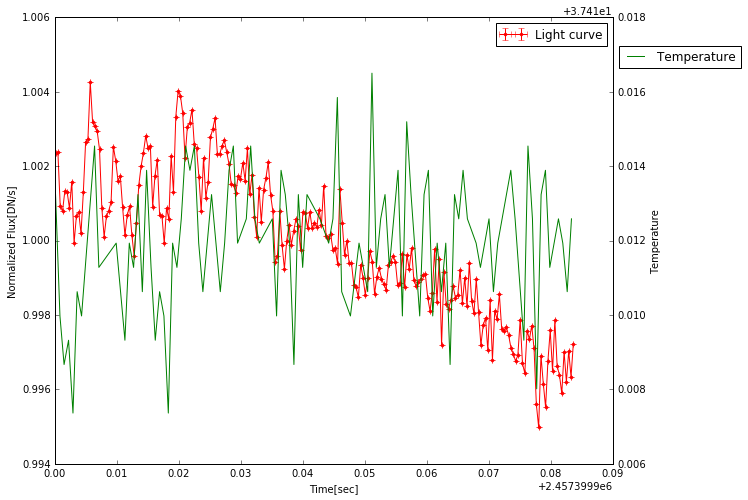

In [141]:
x1 = jd_time + stime
y1 = data6['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))

## Test 7 (FULL4)

In [142]:
hdu_filenames_a17 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL4-6012114105_1_481_SE_2016-01-12T14h25m53/*.red.fits')
len(hdu_filenames_a17)

225

In [143]:
hdu_filenames_b47 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL4-6012114212_1_489_SE_2016-01-12T14h58m10/*.red.fits')
len(hdu_filenames_b47)

225

In [144]:
centers_a17 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a17, red_files = True)
centers_b47 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b47, red_files = True)
data7 = rl.average_residual_flux(centers_a17, centers_b47, 60, 80, 90, 
                                 hdu_filenames_a17, hdu_filenames_b47, red_files = True)

In [145]:
hdu = fits.open(hdu_filenames_a17[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

2457399.98871 2457400.07259 1779 1878


In [146]:
jd_time = data7['Time']/86400

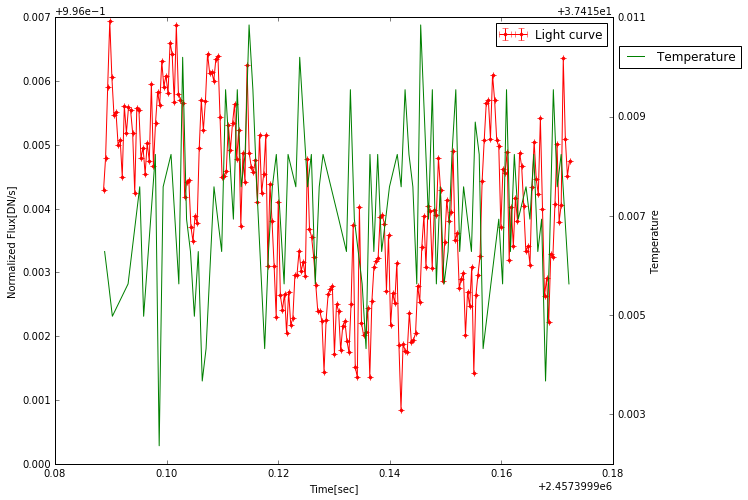

In [147]:
x1 = jd_time + stime
y1 = data7['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))

## Test 8 (FULL5)

In [148]:
hdu_filenames_a18 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL5-6012184421_1_481_SE_2016-01-12T20h26m57/*.red.fits')
len(hdu_filenames_a18)

110

In [150]:
hdu_filenames_b48 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL5-6012185018_1_489_SE_2016-01-12T20h20m15/*.red.fits')
len(hdu_filenames_b48)

110

In [152]:
centers_a18 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a18, red_files = True)
centers_b48 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b48, red_files = True)
data8 = rl.average_residual_flux(centers_a18, centers_b48, 60, 80, 90, 
                                 hdu_filenames_a18, hdu_filenames_b48, red_files = True)

In [153]:
hdu = fits.open(hdu_filenames_a18[1])
header = hdu[0].header
header

stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
etime_str = header['DATE-END']+'T'+header['TIME-END']
stime = Time(stime_str).jd
etime = Time(etime_str).jd
stime_ind = closest_value(x, stime)[0]
etime_ind = closest_value(x, etime)[0]
print stime, etime, stime_ind, etime_ind

2457400.28738 2457400.32839 2139 2187


In [154]:
jd_time = data8['Time']/86400

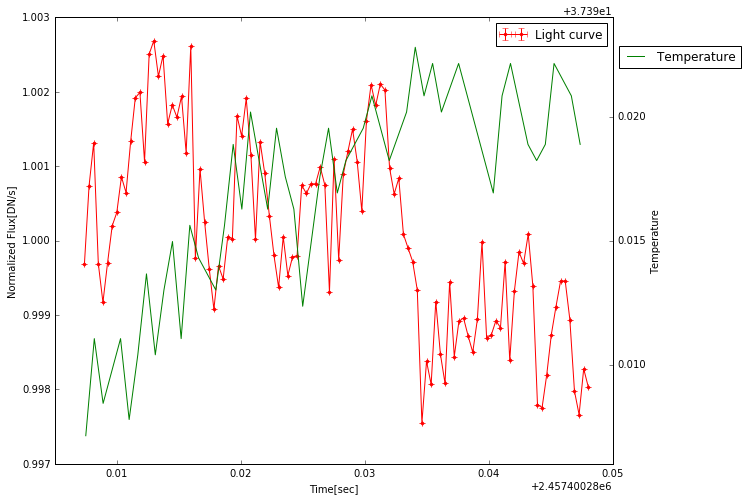

In [155]:
x1 = jd_time + stime
y1 = data8['a1_b4_res_flux']
rl.light_curve(x1, y1, 0, 0, 'r.-', 'Light curve')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.twinx()
x2 = x[stime_ind:etime_ind]
y2 = y[stime_ind:etime_ind]
plt.ylabel('Temperature')
plt.plot(x2, y2, 'g-', label = 'Temperature')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.95))